In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Error Reduction (ER) Algorithm

- Start with initial guess $y_1$.
- Repeat:
  1. Compute frame coefficients using analysis operator: $Y'_i = \theta y_i$.
  2. Assert magnitude constraint: $Y_i = b \cdot \operatorname{sgn}(Y'_i)$.
  3. Update guess using synthesis operator: $y'_i = \theta^* Y_i$.
  4. Assert domain constraint: $y_i = \operatorname{Re}(y'_i)$.

In [2]:
def error_reduction_algorithm(measurement, frame, maxiter=1000, tol=1e-5, print_out=False):
    # loss function
    def loss(y):
        approx = np.abs(frame @ y)
        return np.linalg.norm(approx - measurement)
    
    # initial guess
    y = frame.T @ measurement
    previous_error = loss(y)

    # Iterative phase retrieval (error reduction)
    for i in np.arange(maxiter) + 1:
        # Update guess
        Y = frame @ y                              # get frame coefficients
        Y = measurement * np.exp(1j * np.angle(Y)) # assert measurement
        y = frame.T @ Y                            # get next guess
        y = np.real(y)                             # assert real

        # Print current iteration error
        if print_out:
            print(f"{i}: {loss(y)}")

        # Stopping criteria
        error_change = np.abs(previous_error - loss(y))
        if error_change < tol: # Error is not reducing
            if print_out:
                print(f"Stuck after {i} iterations.")
            break
        elif loss(y) < tol: # Guess is within tolerance
            if print_out:
                print(f"Finished after {i} iterations.")
            break
        elif i == maxiter: # Maximum iterations
            print("Maximum iterations reached.")
        
        # Update error
        previous_error = loss(y)
    
    return y, i

## Minimum Signs (MS) Algorithm

- Start with initial guess $y_1$.
- Repeat:
  1. Compute frame coefficients using analysis operator: $Y'_i = \theta y_i$.
  2. Assert magnitude constraint: $Y_i = b \cdot \operatorname{sgn}(Y'_i)$.
  3. Update guess using synthesis operator: $y'_i = \theta^* Y_i$.
  4. Determine sign vector $s = \pm \operatorname{sgn}(y'_i)$ of that minimizes the loss function.
  5. Assert domain constraint: $y_i = s \cdot \operatorname{Re}(y'_i)$.

In [3]:
def min_signs_algorithm(measurement, frame, maxiter=1000, tol=1e-5, print_out=False):
    # loss function
    def loss(y):
        approx = np.abs(frame @ y)
        return np.linalg.norm(approx - measurement)
    
    # initial guess
    y = frame.T @ measurement
    previous_error = loss(y)

    # Iterative phase retrieval (minimum signs)
    for i in np.arange(maxiter) + 1:
        # Update guess
        Y = frame @ y                              # get frame coefficients
        Y = measurement * np.exp(1j * np.angle(Y)) # assert measurement
        y = frame.T @ Y                            # get next guess
        y = y if loss(y) < loss(-y) else -y        # assert minimum loss
        y = np.real(y)                             # assert real

        # Print current iteration error
        if print_out:
            print(f"{i}: {loss(y)}")

        # Stopping criteria
        error_change = np.abs(previous_error - loss(y))
        if error_change < tol: # Error is not reducing
            if print_out:
                print(f"Stuck after {i} iterations.")
            break
        elif loss(y) < tol: # Guess is within tolerance
            if print_out:
                print(f"Finished after {i} iterations.")
            break
        elif i == maxiter: # Maximum iterations
            print("Maximum iterations reached.")
        
        # Update error
        previous_error = loss(y)
    
    return y, i

## Hybrid Input/Output (HIO) Algorithm

- Start with initial guess $y_1$.
- Repeat:
  1. Compute frame coefficients using analysis operator: $Y'_i = \theta y_i$.
  2. Assert magnitude constraint: $Y_i = b \cdot \operatorname{sgn}(Y'_i)$.
  3. Update guess using synthesis operator: $y'_i = \theta^* Y_i$.
  4. Assert domain constraint: $y_i = \operatorname{Re}(y'_i) + i (\operatorname{Im}(y'_i) - \beta \operatorname{Im}(y_{i-1}))$.

In [4]:
def hybrid_io_algorithm(measurement, frame, beta=0.9, maxiter=1000, tol=1e-5, print_out=False):
    # loss function
    def loss(y):
        approx = np.abs(frame @ y)
        return np.linalg.norm(approx - measurement)
    
    # initial guess
    y = frame.T @ measurement
    previous_error = loss(y)

    # Iterative phase retrieval (HIO)
    for i in np.arange(maxiter) + 1:
        # Update guess
        y_prev = y.copy()
        Y = frame @ y                              # get frame coefficients
        Y = measurement * np.exp(1j * np.angle(Y)) # assert measurement
        y = frame.T @ Y                            # get next guess
        y = y.real + (y.imag - beta*y_prev.imag) * 1j

        # Print current iteration error
        if print_out:
            print(f"{i}: {loss(y)}")

        # Stopping criteria
        error_change = np.abs(previous_error - loss(y))
        if error_change < tol: # Error is not reducing
            if print_out:
                print(f"Stuck after {i} iterations.")
            break
        elif loss(y) < tol: # Guess is within tolerance
            if print_out:
                print(f"Finished after {i} iterations.")
            break
        elif i == maxiter: # Maximum iterations
            print("Maximum iterations reached.")
        
        # Update error
        previous_error = loss(y)
    
    return y, i

## Set up simulations

- `algorithm_switch` chooses an algorithm.
- `simulate` determines whether phase retrieval is successful. Set `plot=True` to see the recovered signal.
- `get_success_rate` runs a number of simulations to approximate the success rate for an algorithm.

In [5]:
def algorithm_switch(method):
    if method == "ER":
        return error_reduction_algorithm
    elif method == "MS":
        return min_signs_algorithm
    elif method == "HIO":
        return hybrid_io_algorithm
    else:
        return min_signs_algorithm
    
def simulate(input_dim, redundancy, method, seed=None, plot=False):

    # Generate random frame
    rng = np.random.default_rng(seed) # random number generator
    frame_dim = int(input_dim * redundancy) # number of frame vectors
    rand_matrix = rng.standard_normal((frame_dim, input_dim))
    F, _ = np.linalg.qr(rand_matrix) # generate orthogonal matrix

    # Generate random signal vector
    x = rng.standard_normal(size=input_dim)

    # Calculate frame coefficients
    b = np.abs(F @ x)

    # Do phase retrieval
    algorithm = algorithm_switch(method)
    y, iters = algorithm(b, F)

    # Check for success
    success = np.isclose(x,y).all() or np.isclose(x,-y).all()

    # Plot signals
    if plot:
        t = np.linspace(0, 1, input_dim)
        ax = plt.axes()
        ax.stem(t, x)
        ax.stem(t, y, 'r')
        title = f"Iterations: {iters},  Redundancy: {redundancy}"
        ax.set_title(title)
        plt.show()

    return success

# Approximate success rates for given dimension and redundancy
def get_success_rate(input_dim, redundancy, method, iterations):
    succ_count = 0
    for _ in range(iterations):
        succ_count += simulate(input_dim, redundancy, method)
    return succ_count / iterations

## Algorithm Performance

Change the input dimension `n` and redundancy `r` to see how it affects the success rate for an algorithm.
When `n = 19` and `r = 5`, the ER algorithm has a success rate of about 0.15.

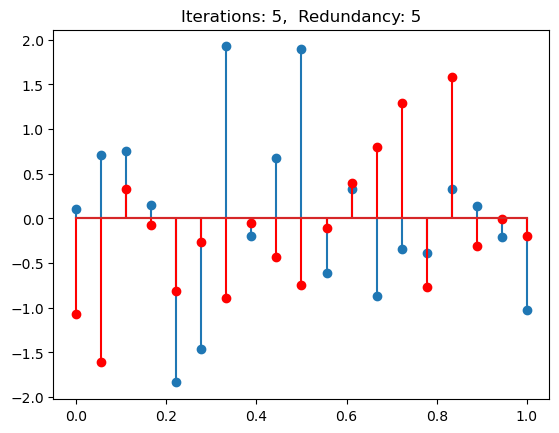

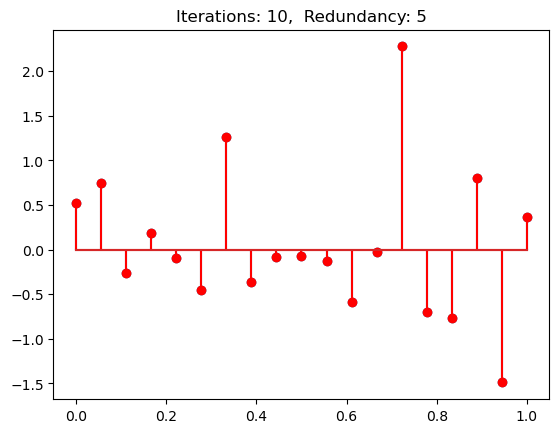

Success rate with dimension 19 and redundancy 5: 0.14


In [6]:
n = 19 # input dimension
r = 5  # redundancy
method = "ER" # phase retrieval method
simulate(n, r, method, seed=99, plot=True)
simulate(n, r, method, seed=100, plot=True)
sr = get_success_rate(n, r, method, 500)
print(f"Success rate with dimension {n} and redundancy {r}: {sr}")

### Error Reduction Success Rates

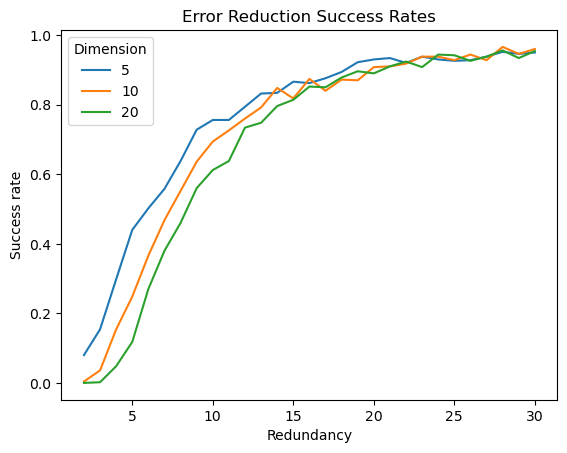

In [7]:
nlist = 5, 10, 20
rlist = np.arange(2,31)

for n in nlist:
    succ_rates = [get_success_rate(n, r, "ER", 500) for r in rlist]
    plt.plot(rlist, succ_rates, label=n)

plt.legend(title="Dimension")
plt.title(f"Error Reduction Success Rates")
plt.xlabel("Redundancy")
plt.ylabel("Success rate")
plt.show()

### Minimum Signs Success Rates

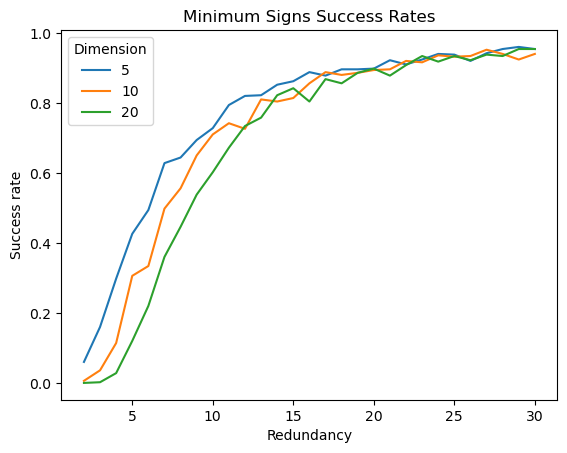

In [8]:
nlist = 5, 10, 20
rlist = np.arange(2,31)

for n in nlist:
    succ_rates = [get_success_rate(n, r, "MS", 500) for r in rlist]
    plt.plot(rlist, succ_rates, label=n)

plt.legend(title="Dimension")
plt.title(f"Minimum Signs Success Rates")
plt.xlabel("Redundancy")
plt.ylabel("Success rate")
plt.show()

### Hybrid Input/Output Success Rates

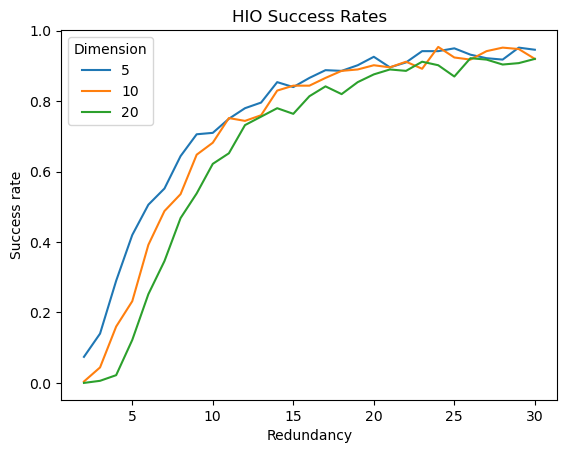

In [9]:
nlist = 5, 10, 20
rlist = np.arange(2,31)

for n in nlist:
    succ_rates = [get_success_rate(n, r, "HIO", 500) for r in rlist]
    plt.plot(rlist, succ_rates, label=n)

plt.legend(title="Dimension")
plt.title(f"HIO Success Rates")
plt.xlabel("Redundancy")
plt.ylabel("Success rate")
plt.show()